# Homework 5 - Explore Wikipedia's hyperlinks network

## Data handling

In [4]:
import scripts.functionality as funcs
from scripts.graph import Graph
import pandas as pd
from collections import defaultdict
from scripts.graph import Graph

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
link_dict = funcs.read_graph()
link_dict = defaultdict(set, link_dict)

##### Read Data and save to json

In [40]:
pages_category = funcs.read_pages_category(filename='data/wiki-topcats-categories.txt')
funcs.write_json('data/page_category.json', pages_category)

In [41]:
name_page = funcs.read_name_page(filename='data/wiki-topcats-page-names.txt')
funcs.write_json('data/name_page.json', name_page)

##### Read data from json

In [42]:
# pages_category: Key is the category, and value is a list of integers which is associated to a set of articles
# name_page: Key is an integer that identifies the article. The value associated is the name of the article

pages_category = funcs.read_json('data/page_category.json')
name_page = funcs.read_json_int_key('data/name_page.json')

##### Understanding the data

- Edge_ID seems to be unique. This is the main reason for which we think it is the unique edge identifier
- From pages_category we have a set of category names (e.g. Members_of_the_Parliament_of_Great_Britain_for_Scottish_constituencies). These are the keys of the dictionary.
- The values in each of these keys are the pages contained in this category (e.g. '34683')
- The actual name of this page can be found in the dictionary name_page (the result seems to be a page somewhat related to that specific category)

In [43]:
categories = list(pages_category.keys())
for c in categories:
    if not (5000 < len(pages_category[c]) < 30000):
        pages_category.pop(c)

In [44]:
# Find articles assigned to multiple categories
article_category = funcs.revert_dict_list(pages_category)

In [45]:
# Randomly pick one category for each article
unique_category = funcs.uniformly_pick_article_category(article_category)

In [46]:
# Revert back from articles to categories
final_pages_category = funcs.revert_dict(unique_category)
funcs.write_json('data/final_pages_category.json', final_pages_category)

In [47]:
pages_category = funcs.read_json('data/final_pages_category.json')

In [48]:
len(pages_category.keys())

21

In [49]:
vertices = set()
for c in pages_category:
    vertices.update(pages_category[c])
len(vertices)

149794

<br>

## Question 1 ~ Build the graph

As the first step, we build the graph leveraging the custom Graph class we defined:

In [50]:
g = Graph.from_dict(link_dict)

#### Is the graph directed?

The graph is directed, since each node corresponds to a Wikipedia article and each edge corresponds to a web link from an article to another.

#### How many articles are we considering?

The number of articles we are considering is equal to the number of nodes in the graph, that is the number of nodes which appear in our reduced dataset.

In [13]:
print(f'Number of articles:\t{g.n_vertices_}')

Number of articles:	98343


#### How many hyperlinks between pages exist?

The number of hyperlinks between the pages is equal to the number of edges in the graph.

In [14]:
print(f'Number of hyperlinks:\t{g.n_edges_}')

Number of hyperlinks:	483094


#### Compute the average number of links in an arbitrary page

The average number of links in an arbitrary page is simply equal to the fraction of the number of links over the number of vertices.

In [15]:
print(f'Average number of links in an arbitrary page:\t{round(g.n_edges_ / g.n_vertices_,3)}')

Average number of links in an arbitrary page:	4.912


#### What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?

The density of a graph is the ratio between the effective number of edges in the graph and the maximum number of possible edges of the graph. That is, let $\mathbf{G}(V, E)$ a directed graph, where $V$ is the set of nodes of the graph and $E$ is the set of edges. Then the density is:

$$D=\frac{|E|}{2{V\choose 2}}=\frac{|E|}{|V|\cdot \left(|V| - 1\right)}$$

A graph is said to be *dense* if $D\approx 1$. Otherwise, it is said *sparse* if $D\approx 0$.

We now compute the density of the our graph.

In [16]:
print(f'Density of the graph:\t{g.density_}')

Density of the graph:	4.995e-05


The magnitude order of the density of the graph is order of 10<sup>-4</sup>, then it is a sparse graph.

#### Visualize the nodes' degree distribution

The nodes' degree distribution shows how many vertices the graph has with degree d. 

For the graph we are analysing, the degree distribution is the following:

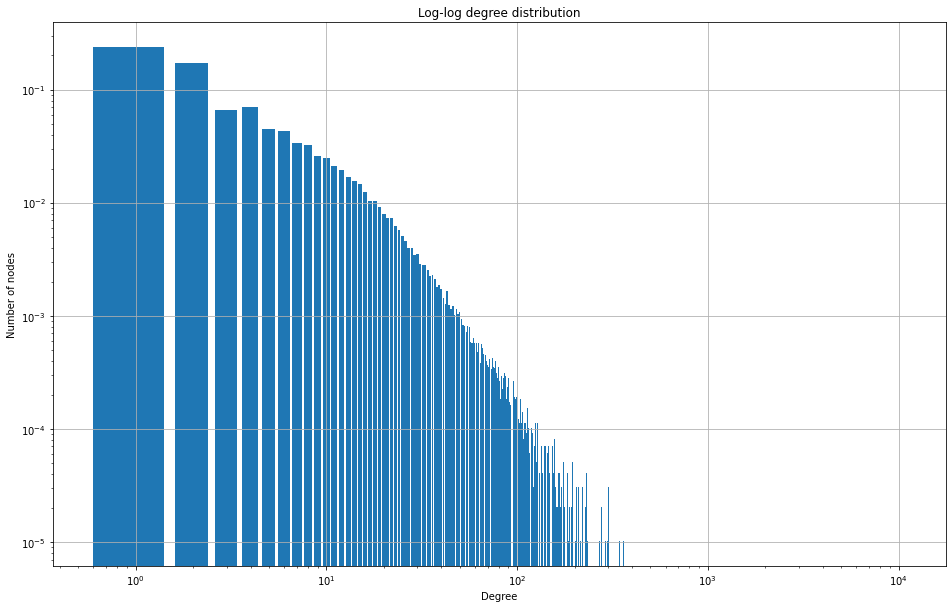

In [9]:
g.plot_degree_distro(normalize=True, log=True)

## Question 3

In [51]:
categories = funcs.read_graph_category(g)

In [52]:
vertices = set()
for c in categories:
    vertices.update(categories[c])
len(vertices)

98343

In [55]:
[(c,len(categories[c])) for c in categories.keys()]

[('American_film_actors', 9084),
 ('American_films', 7573),
 ('American_television_actors', 6493),
 ('Association_football_defenders', 2140),
 ('Association_football_forwards', 2520),
 ('Association_football_midfielders', 2793),
 ('Asteroids_named_for_people', 2371),
 ('Black-and-white_films', 5143),
 ('Debut_albums', 2553),
 ('English-language_films', 13354),
 ('English_footballers', 3607),
 ('Harvard_University_alumni', 2966),
 ('Indian_films', 2741),
 ('Main_Belt_asteroids', 8627),
 ('Major_League_Baseball_pitchers', 3307),
 ('Members_of_the_United_Kingdom_Parliament_for_English_constituencies', 6431),
 ('Place_of_birth_missing_(living_people)', 2533),
 ('Rivers_of_Romania', 7662),
 ('The_Football_League_players', 3581),
 ('Year_of_birth_missing', 1466),
 ('Year_of_death_missing', 1398)]

In [56]:
len(categories)

21

In [29]:
wg = g.dist_weighted_graph(categories['Year_of_death_missing'])

6it [00:01,  4.40it/s]


In [28]:
wg = g.dist_weighted_graph(categories['Action_comedy_films'])

6it [00:01,  3.19it/s]


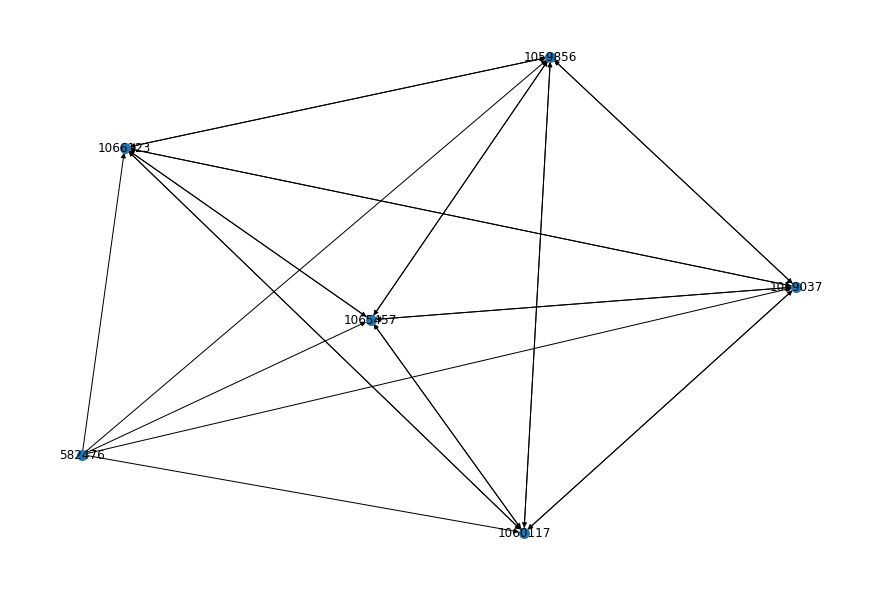

In [30]:
wg.plot_graph()

In [15]:
# wgg = wg.to_undirected()
# wgg.nearest_neighbor(1028673) + (wgg.n_vertices_ / 2) * 10000
wg.nearest_neighbor(1060920)

15

In [57]:
g.minimum_cat_walk(categories['Year_of_death_missing'])

1398it [01:18, 17.84it/s]


1264284
Not possible!


## Question 5 ~ Sort categories

In this task we are asked to sort all other categories according to their distances from a given category. The distance between two categories is defined as the median of the distances between each pair of nodes in the two categories.

As a first step, we load the categories of the graph:

In [58]:
categories = funcs.read_graph_category(g)

At this point, we compute the category distances:

In [61]:
sorted_cat = g.category_distance('Year_of_death_missing', categories)

1398it [01:10, 19.77it/s]


Since the list can be very long, we visualize only the first 15 elements, i.e. the 15 nearest categories:

In [62]:
sorted_cat

[array(['American_film_actors', 'inf'], dtype='<U67'),
 array(['The_Football_League_players', 'inf'], dtype='<U67'),
 array(['Rivers_of_Romania', 'inf'], dtype='<U67'),
 array(['Place_of_birth_missing_(living_people)', 'inf'], dtype='<U67'),
 array(['Members_of_the_United_Kingdom_Parliament_for_English_constituencies',
        'inf'], dtype='<U67'),
 array(['Major_League_Baseball_pitchers', 'inf'], dtype='<U67'),
 array(['Main_Belt_asteroids', 'inf'], dtype='<U67'),
 array(['Indian_films', 'inf'], dtype='<U67'),
 array(['Harvard_University_alumni', 'inf'], dtype='<U67'),
 array(['Year_of_birth_missing', 'inf'], dtype='<U67'),
 array(['English_footballers', 'inf'], dtype='<U67'),
 array(['Debut_albums', 'inf'], dtype='<U67'),
 array(['Black-and-white_films', 'inf'], dtype='<U67'),
 array(['Asteroids_named_for_people', 'inf'], dtype='<U67'),
 array(['Association_football_midfielders', 'inf'], dtype='<U67'),
 array(['Association_football_forwards', 'inf'], dtype='<U67'),
 array(['Associat

The results above are computed with the Dijkstra algorithm ($O((V+E)\log V)$). The results below are computed with the BFS ($O(V+E)$). 

In [31]:
sorted_cat = g.category_distance('American_agnostics', categories)

In [39]:
sorted_cat[:15]

['Jews_from_Galicia_(Eastern_Europe)',
 'Metafictional_works',
 'People_from_Munich',
 'Businesspeople_from_California',
 'Kennedy_Center_honorees',
 'American_blues_musicians',
 'Olivier_Award_winners',
 'Hungarian_emigrants_to_the_United_States',
 'Deaths_from_cerebral_hemorrhage',
 'Historians_of_Nazism',
 'San_Diego_State_University_alumni',
 '1960s_American_television_series',
 'Australian_child_actors',
 'Films_set_within_one_day',
 'Films_shot_in_Arizona']